# Anomaly detection Assignment

Anomaly detection is a technique for recognizing data points that differ significantly from the rest of the data in a dataset, and it uses past data or known knowledge to decide what is inside the expected range.  This method plays a crucial role in guaranteeing data quality and security across multiple domains.
Sensor dataset consists of 52 sensor units and records 7 system failures. An anomaly detection algorithm can learn the machine's normal behavior or expected patterns by analyzing sensor readings, operational parameters, and other relevant data. When a deviation from this normal behavior occurs, it may signal a potential failure or malfunction. The hypothesis is that a pump's sensor readings will show abnormal values prior to a failure, and these anomalies can be detected using anomaly detection techniques [Study Case: Anomaly Detection]

**Hypothesis:** The hypothesis is that the sensor readings of a pump will generate not normal values in case of an (upcoming) failure, and these can be determined with anomaly detection. 

I have decided to contribute to the first and fourth options provided in the assignments list.  I would analyze the plot to evaluate the algorithm performance, assess the algorithm, evaluating the hypothesis. And also find the best configuration for the best selected model.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from anamoly import Anomaly
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

# The data

In [2]:
# source: https://www.kaggle.com/datasets/nphantawee/pump-sensor-data
df = pd.read_csv('sensor.csv').drop('Unnamed: 0', axis=1)
df_origin = df.copy()

## Inspect data

In [3]:
df.shape

(220320, 54)

In [4]:
df.machine_status.value_counts()

machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64


- Normal: Normal state of the machine, fully functional
- Broken: Machine not working
- Recovering: Machines are in recovery state to function normally

In [5]:
#missing values
percentage_missing = df.isnull().sum().sort_values(ascending=False)/len(df)*100
percentage_missing.head() # show 5 largest missing %

sensor_15    100.000000
sensor_50     34.956881
sensor_51      6.982117
sensor_00      4.633261
sensor_07      2.474129
dtype: float64

In [6]:
anomaly = Anomaly(df)
anomaly.df = anomaly.drop_nan_columns(nan_threshold=34)
# anomaly.df 

We have dropped the columns which have data missing percentage value above or equal to 34. This way we removed the unrelated sensors.

## Visualization

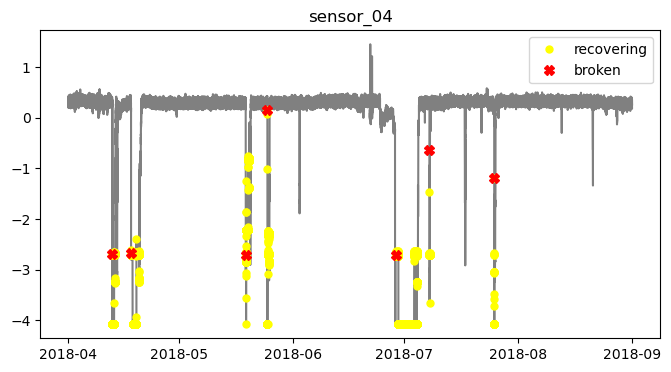

In [7]:
anomaly.plot_sensor(column='sensor_04')

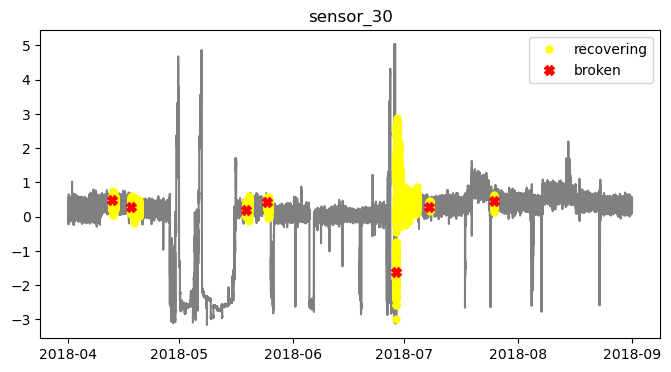

In [8]:
anomaly.plot_sensor(column='sensor_30')

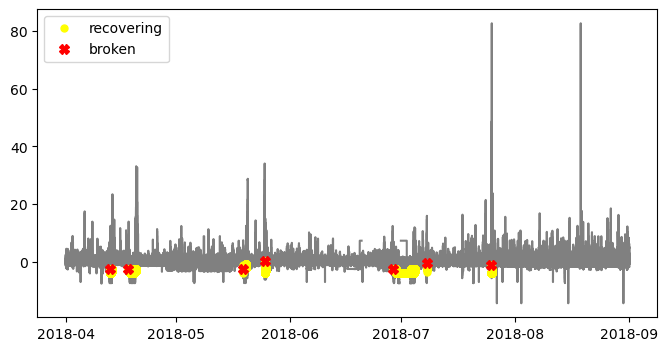

In [9]:
anomaly.plot_sensor()

From the plot visualization, we can see that yellow represents the machine's recovery state, while red indicates a broken status.  

For `sensor_04`, the signal aligns well with the machine's broken and recovery states—its deviations correspond closely to the points where the machine is marked as broken or recovering.  

However, for `sensor_30`, the signal behaves differently. When the machine is in a broken or recovery state, the signal remains normal, but when the signal deviates, the machine itself stays in a normal state.  

Although we plotted all sensors together after normalizing the signals, the visualization does not clearly reveal a consistent pattern of deviations.

## Plot Analysis

We will look at the plot to see how  `IsolationForest`, `OneClassSVM`, `LocalOutlierFactor`, and `EllipticEnvelope` detect anomalies in the data. We will visualize the results to assess the performance of the anomaly detection. However, relying on the plot will not be sufficient for a complete evaluation.

Area Under Curve (AUC), derived from the ROC curve, measures detection performance and represents the probability that an anomaly detection algorithm scores a normal instance lower than an anomalous one, as shown in [1]. That's why this paper[2] thinks AUC is a perfect evaluation method and ideal for comparison. We will use AUC score and ROC curve as an evaluation metric for all the algorithms.

In [10]:

# The anomaly detection algorithms we use (IsolationForest, OneClassSVM, LocalOutlierFactor, and EllipticEnvelope) 
# classify data points as either normal (+1) or anomalous (-1). 
# However, our dataset contains three classes: Normal, Broken, and Recovering.
# To align with the algorithms' binary classification, we treat both "broken" and "recovering" states as anomalies.
# After a machine enters a "broken" state, it goes through a "recovering" phase, but it is not fully functional yet.
# We had two options: classify "recovering" as normal or as an anomaly.
# Considering that the machine is still not operating normally, we chose to classify "recovering" as an anomaly, similar to the "broken" state.


outliers_fraction = 1 - (df['machine_status'].value_counts()['NORMAL']/len(df))
outliers_fraction

0.06574074074074077

In [11]:

isolation_forest = IsolationForest(contamination=outliers_fraction, n_jobs = -1)
svm_one_class = svm.OneClassSVM(nu=outliers_fraction)
local_outliner = LocalOutlierFactor(contamination=outliers_fraction, n_jobs = -1)
robust_covariance = EllipticEnvelope(contamination=outliers_fraction)

#### Isolation Forest

In [12]:
isolation_forest_preds = anomaly.anomaly_detection(isolation_forest)

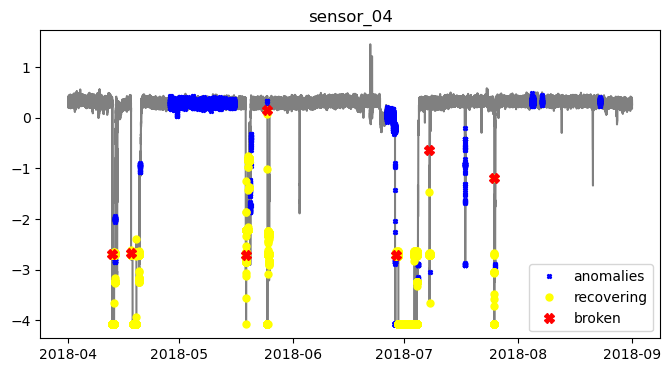

In [13]:
# for one sensor
anomaly.plot_sensor(column = 'sensor_04',preds=isolation_forest_preds)

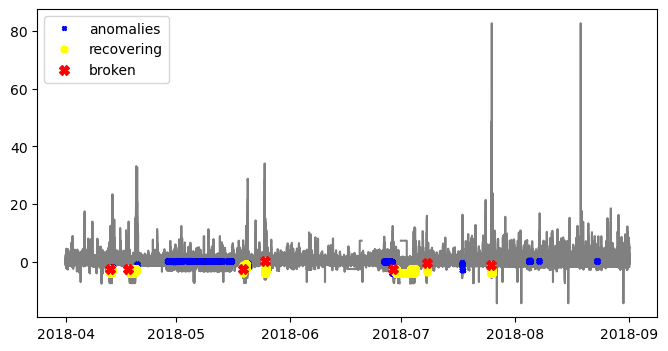

In [14]:
# for  all the sensor
anomaly.plot_sensor(preds=isolation_forest_preds)

When we see the individual sensor plots or all sensor data, we observe that `Isolation Forest` classifies a large continuous segment of normal data as anomalies. This indicates a high false positive rate. Though it detects many true anomalies correctly, but it also includes many unnecessary detections. `AUC` evaluation metric, can provide deeper insights into its performance.

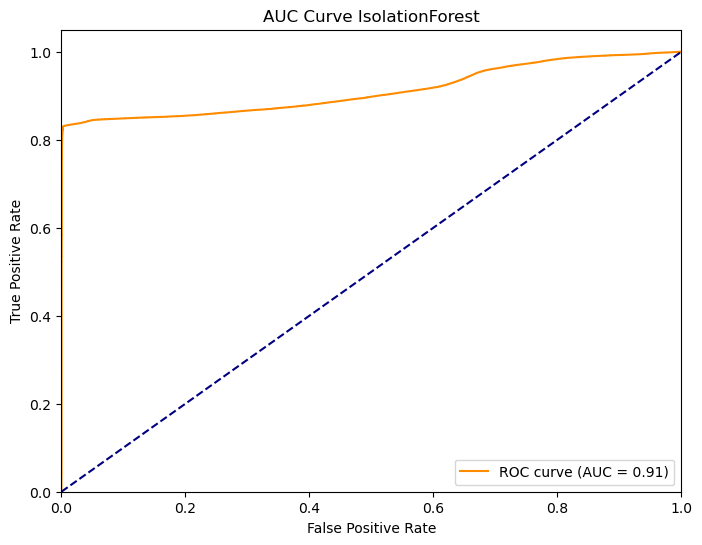

In [15]:
tpr_iso1, fpr_iso_1,auc_iso1 = anomaly.return_tpr_fpr_auc(isolation_forest, anomaly.X, anomaly.return_target())
model_name_iso= str(isolation_forest).split('(')[0]
anomaly.plot_auc(model_name_iso,tpr_iso1, fpr_iso_1,auc_iso1)

`AUC` score is pretty good. But as we saw earlier, because of misclassification, it has high false positive rate. To find the exact number, we evaluate the F1 score for this. 

              precision    recall  f1-score   support

     Anomaly       0.42      0.42      0.42     14484
      Normal       0.96      0.96      0.96    205836

    accuracy                           0.92    220320
   macro avg       0.69      0.69      0.69    220320
weighted avg       0.92      0.92      0.92    220320



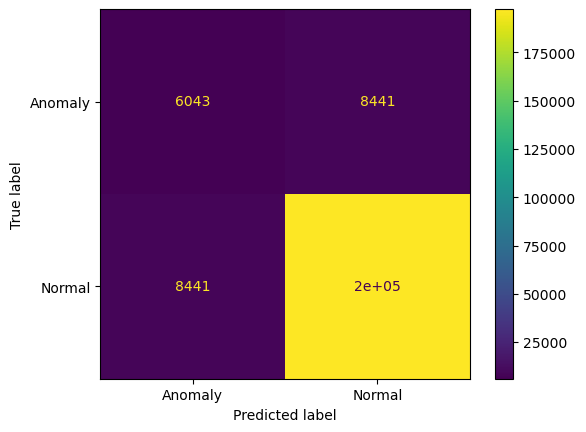

In [16]:
anomaly.evaluation(isolation_forest_preds)

F1 score is not good for anomalies only 42%. Isolation forest assumes anomalies are few and different in feature space. As there are fluctuation in normal state, Isolation forest is unable to detect it.

#### SVM One Class

In [17]:
svm_one_class_preds = anomaly.anomaly_detection(svm_one_class)

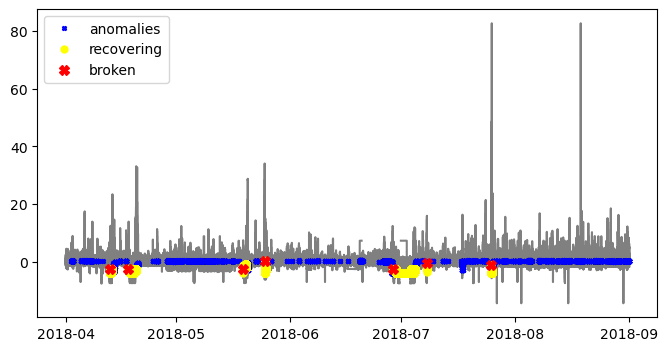

In [19]:
# for all the sensor
anomaly.plot_sensor(preds=svm_one_class_preds)

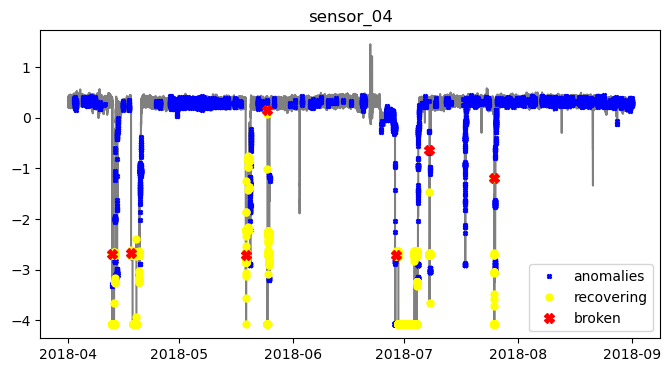

In [20]:
# for one sensor
anomaly.plot_sensor(column = 'sensor_04',preds=svm_one_class_preds)

From individual sensor plot or all the sensor plot, we could see that `One Class Support Vector Machine` has identified lots of normal datapoints as anomalies. Blue points indicating the anomalies. But that point, machine was in normal state. It is misclassifying a huge chunk of data as anomalies. `AUC` score visualize this phenomenon in a better way.

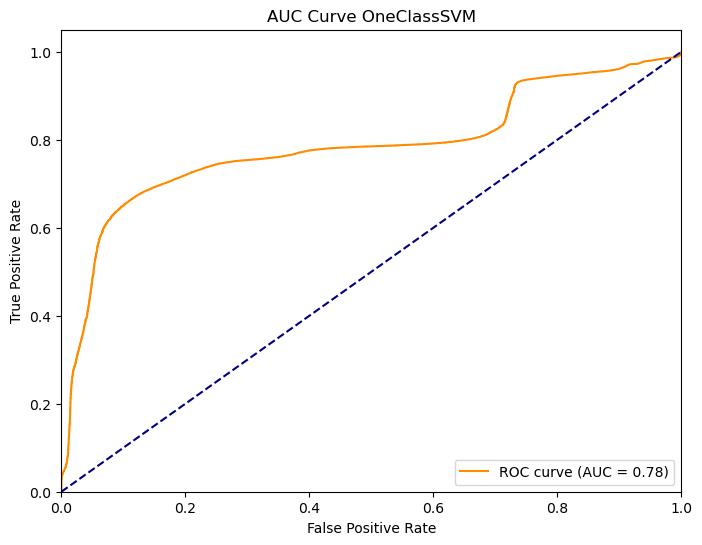

In [21]:
tpr_svm1, fpr_svm_1,auc_svm1 = anomaly.return_tpr_fpr_auc(svm_one_class, anomaly.X, anomaly.return_target())
model_name_svm= str(svm_one_class).split('(')[0]
anomaly.plot_auc(model_name_svm,tpr_svm1, fpr_svm_1,auc_svm1)

The curve rises steeply initially by correctly classifying many true anomalies with a low false positive rate. Then in the middle, the curve flattens, indicating that as the model classifies more anomalies with more false positives. Toward the end, it detects more anomalies but at a high cost of misclassifications. This may indicate that the SVM overfits to normal data, causing it to misclassify normal fluctuations as anomalies. This suggests SVM struggles with normal fluctuations and overfits. The lower AUC score shows it performs worse than Isolation Forest.

              precision    recall  f1-score   support

     Anomaly       0.42      0.42      0.42     14484
      Normal       0.96      0.96      0.96    205836

    accuracy                           0.92    220320
   macro avg       0.69      0.69      0.69    220320
weighted avg       0.92      0.92      0.92    220320



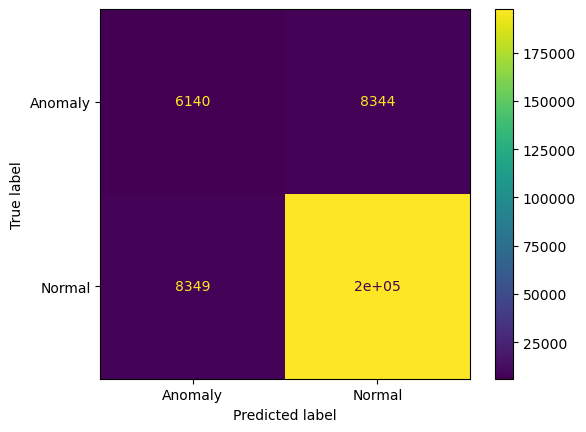

In [22]:
anomaly.evaluation(svm_one_class_preds)

The F1 scores for SVM and Isolation Forest are the same, but the number of true positives, false positives, and false negatives differ.
This means while both models achieve a similar balance between precision and recall, but they classify both instances differently. SVM identifies more true anomalies but the false positive rate is higher than isolation forest.


#### Local Outlier Factor

In [23]:
local_outliner_preds = anomaly.anomaly_detection(local_outliner, local_outlier=True)

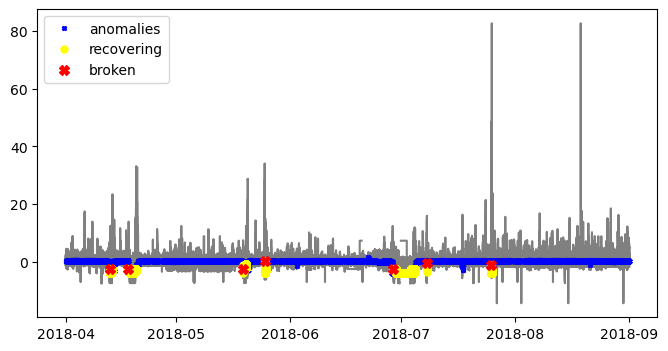

In [24]:
anomaly.plot_sensor(preds=local_outliner_preds)

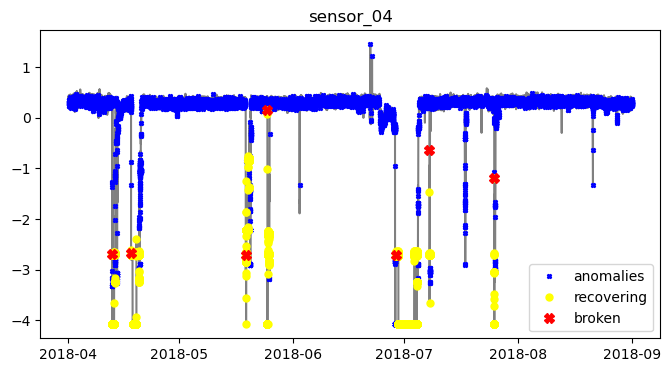

In [25]:
anomaly.plot_sensor(column = 'sensor_04',preds=local_outliner_preds)

`Local Outlier Factor (LOF)` almost identifies all the points as anomalies. LOF focuses on local patterns. As the dataset has variations, LOF struggle to differentiate between normal fluctuations and anomalies. May be that's why it is considering all the small deviations as anomalies.

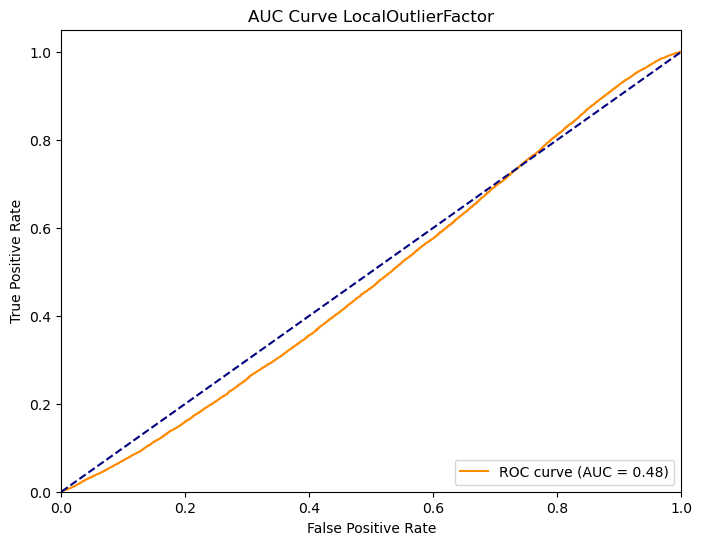

In [26]:
tpr_local1, fpr_local1, auc_local1 = anomaly.return_tpr_fpr_auc(local_outliner, anomaly.X, anomaly.return_target())
model_name_local= str(local_outliner).split('(')[0]
anomaly.plot_auc(model_name_local,tpr_local1, fpr_local1, auc_local1)


`AUC` score of .48 suggesting that model is performing poorly than random guessing.  This was expected after seeing the plot as it was misclassifying normal variations as anomalies, leading to high false positive and false negative rates. F1 score can clarify how many data points it could pick correctly.

              precision    recall  f1-score   support

     Anomaly       0.16      0.16      0.16     14484
      Normal       0.94      0.94      0.94    205836

    accuracy                           0.89    220320
   macro avg       0.55      0.55      0.55    220320
weighted avg       0.89      0.89      0.89    220320



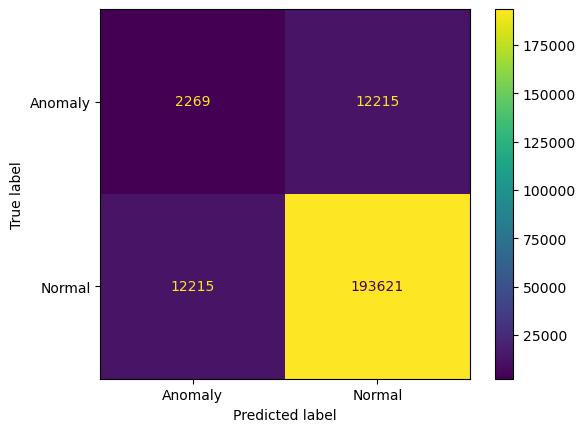

In [27]:
anomaly.evaluation(local_outliner_preds)

Only `2269` data points it could correctly identified as anomalies. Rest of the normal data is misclassified as anomalies. So for this dataset, this algorithm is not suitable for detecting anomalies. 

#### Robust covariance

In [28]:
robust_covariance_preds = anomaly.anomaly_detection(robust_covariance)

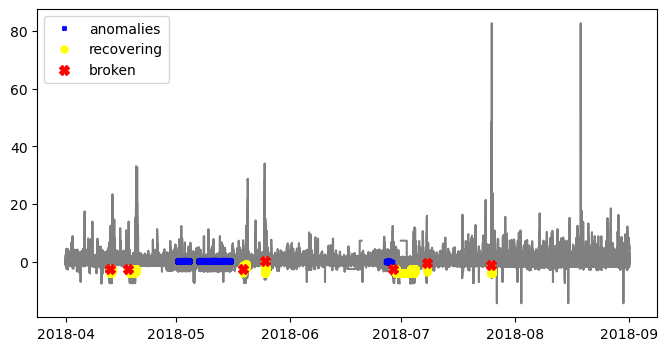

In [29]:
anomaly.plot_sensor(preds=robust_covariance_preds)

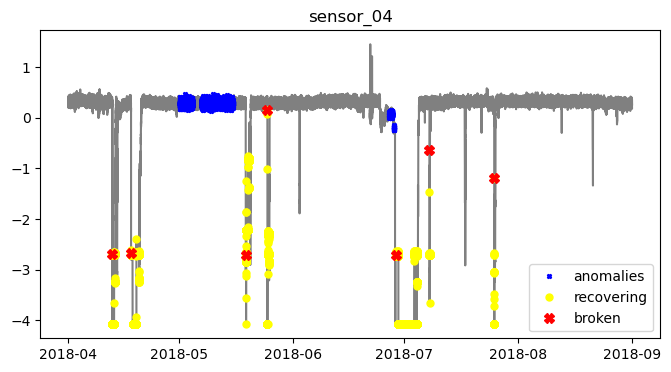

In [30]:
anomaly.plot_sensor(column = 'sensor_04',preds=robust_covariance_preds)

From single sensor plot or all the sensor plot, we could see that `Robust covariance` is detecting normal data points as anomalies. In recoving or broken state, there is no points detected as anomalies. The model seems to under-detect anomalies, missing some extreme spikes. 



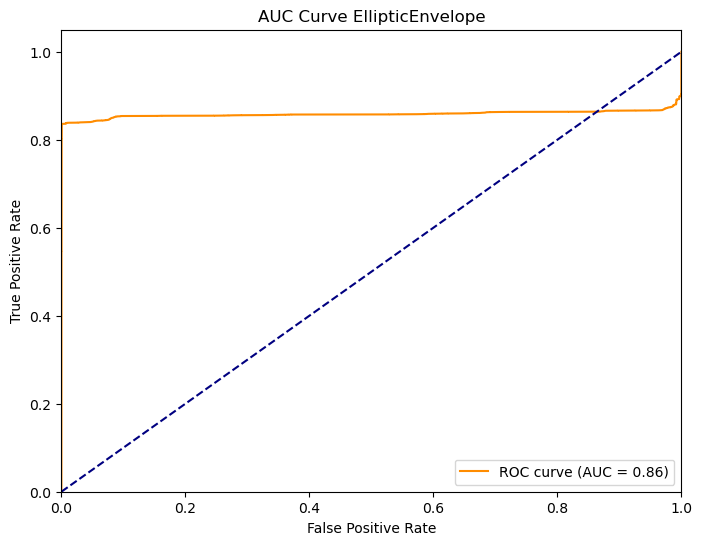

In [31]:
tpr_robust1, fpr_robust1, auc_robust1 = anomaly.return_tpr_fpr_auc(robust_covariance, anomaly.X, anomaly.return_target())
model_name_robust= str(robust_covariance).split('(')[0]
anomaly.plot_auc(model_name_robust,tpr_robust1, fpr_robust1, auc_robust1)

The high `AUC` score suggests good model performance. However, the nearly flat curve indicates a high false positive rate, meaning the model misclassifies many normal instances as anomalies.  With the F1 score, we can see the actual balance between precision and recall, helping us understand how well the model truly differentiates anomalies from normal data.

              precision    recall  f1-score   support

     Anomaly       0.00      0.00      0.00     14484
      Normal       0.93      0.93      0.93    205836

    accuracy                           0.87    220320
   macro avg       0.46      0.46      0.46    220320
weighted avg       0.87      0.87      0.87    220320



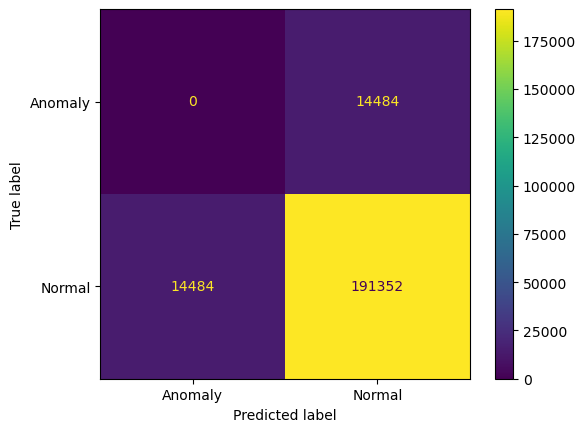

In [32]:
anomaly.evaluation(robust_covariance_preds)

An anomaly score of 0% suggests that the model fails to identify any actual anomalies, as seen in the plot. The model is biased toward the normal class. Despite its high AUC score, it lacks precision and struggles to distinguish true anomalies from normal variations.

#####  Anomaly predictins at wrong places: 

Based on F1 scores:  

- **One-Class SVM** had scattered predictions but still detected some anomalies.  
- **Robust Covariance** produced concentrated predictions but mostly in non-anomalous regions, leading to poor anomaly detection.  
- **Local Outlier Factor** also had scattered predictions but with much lower accuracy.  
- **Isolation Forest** detected anomalies in clusters and achieved the same F1 score as **One-Class SVM**, indicating similar but more localized performance.

## False Positive Mitigation

We observed that some sensors displayed deviations from normal behavior, although the machine was operating normally during those periods. These predictions are false positives. False positives are common phenomenon in anomaly detection. Several technieques have been suggested by earlier research on how to mitigate false positives. The paper [3] proposes mitigating false positives in anomaly detection for behavioral malware detection by using deep learning models combined with adversarial training and confidence-based filtering to improve detection accuracy. On the other hand, The paper [4] proposes mitigating false positives in time series anomaly detection by using a two-stage methodology: the first stage detects anomalies using a multivariate anomaly detector, while the second stage trains a separate classifier on the anomaly detector's outputs to distinguish between true and false positives, refining the final anomaly labels.

In this assignment, we focused solely on classical machine learning algorithms for anomaly detection. Therefore, we opted for **manual plot analysis** to investigate potential data irregularities that might contribute to the elevated rate of false positives.

#### Visualization

sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09


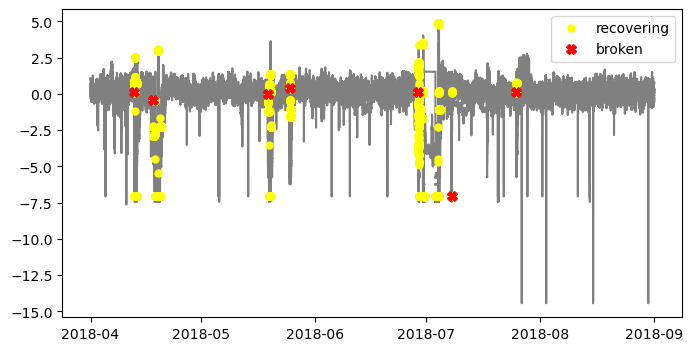

sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20


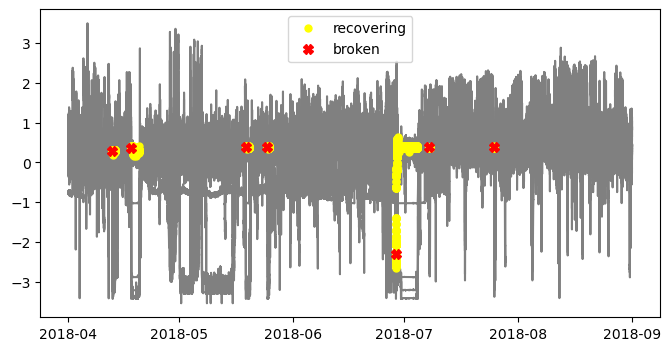

sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30


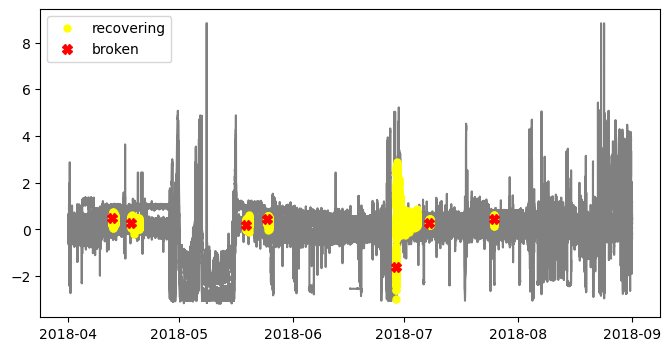

sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40


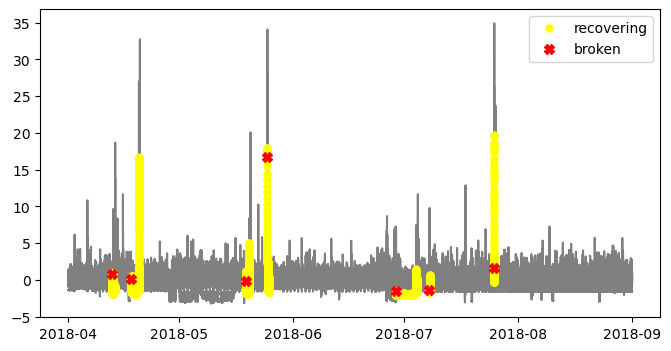

sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51


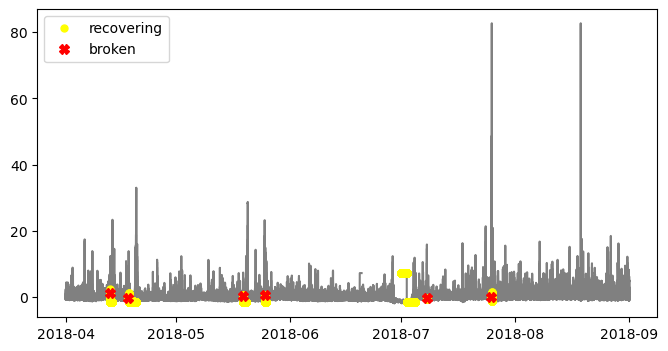

In [36]:
sensors = [sensor for sensor in anomaly.df.columns if sensor.startswith('sensor')]
for i in range(0,len(sensors),10):
    print(",".join(sensors[i:i+10]))
    anomaly.plot_sensor(column=sensors[i:i+10])

We could see a clear deviation when plot sensors 20-29, also we found few sensors from 10-15 are deviated. 

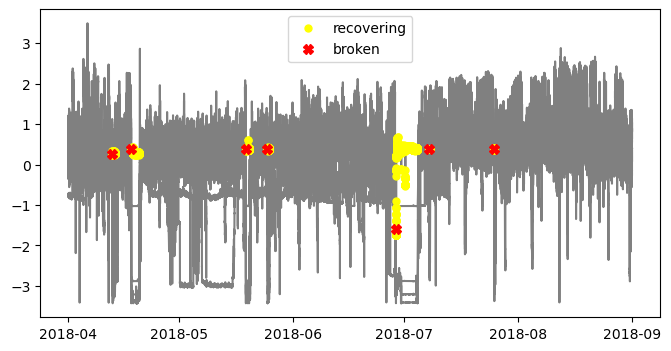

In [37]:

anomaly.plot_sensor(column=sensors[10:15])

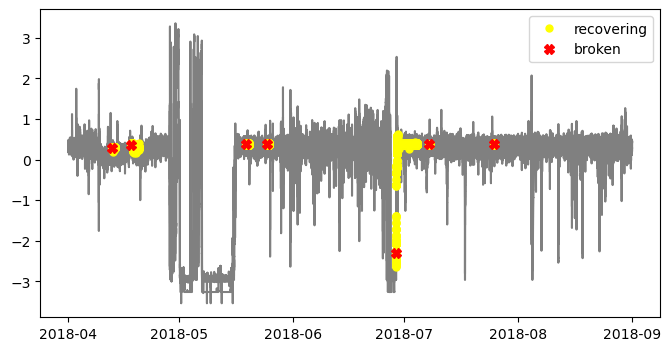

In [38]:
anomaly.plot_sensor(column=sensors[16:20])

15-20 sensors clearly displayes deviation

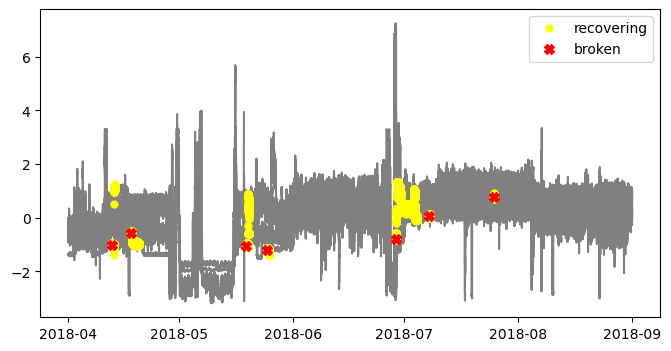

In [39]:
anomaly.plot_sensor(column=sensors[30:36])

30-36 sensors clearly displayes deviation

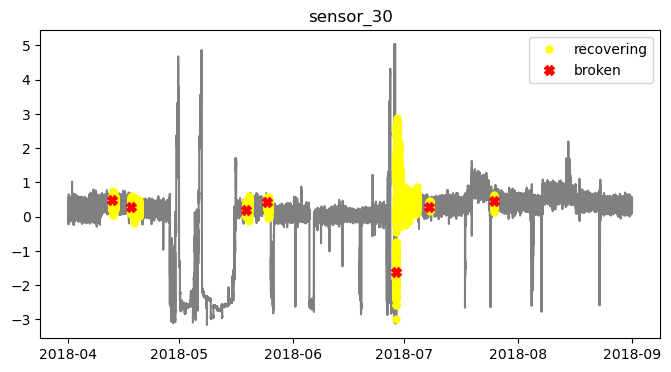

In [40]:
anomaly.plot_sensor(column='sensor_30')

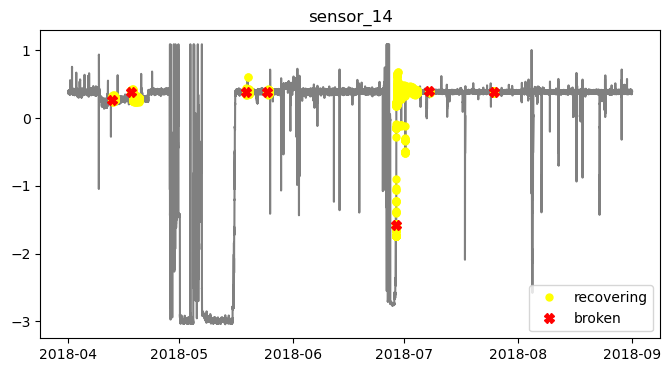

In [41]:
anomaly.plot_sensor(column='sensor_14')

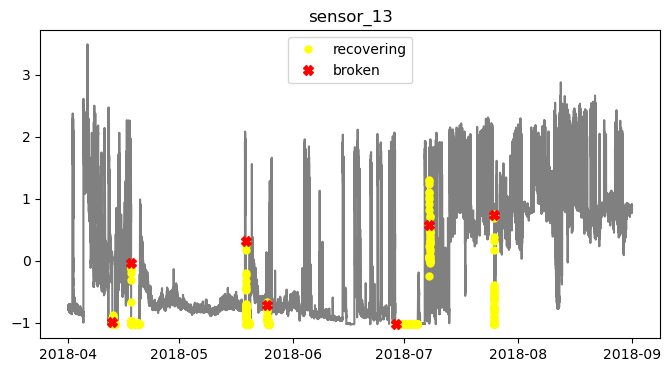

In [42]:
anomaly.plot_sensor(column='sensor_13')

This signal is also unreliable since it shows two different patter over time

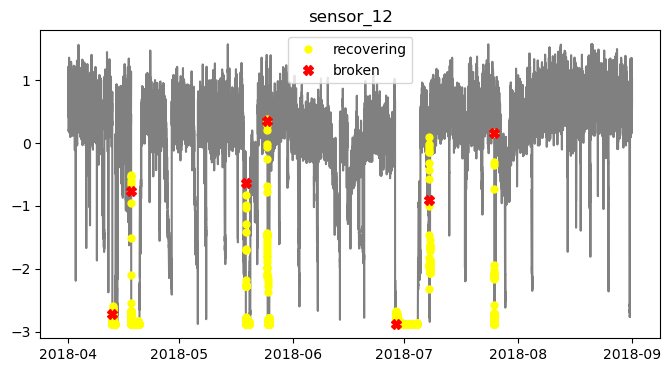

In [43]:
anomaly.plot_sensor(column='sensor_12')

It seems reliable. The abonormality follows the deviation of the pattern

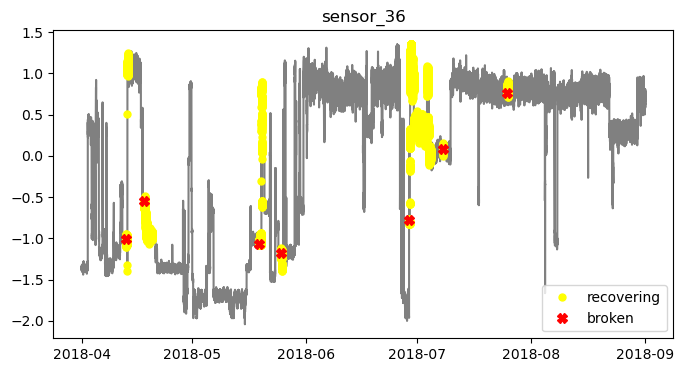

In [44]:
anomaly.plot_sensor(column='sensor_36')

Clear deviation without any breakdwon makes it unreliable

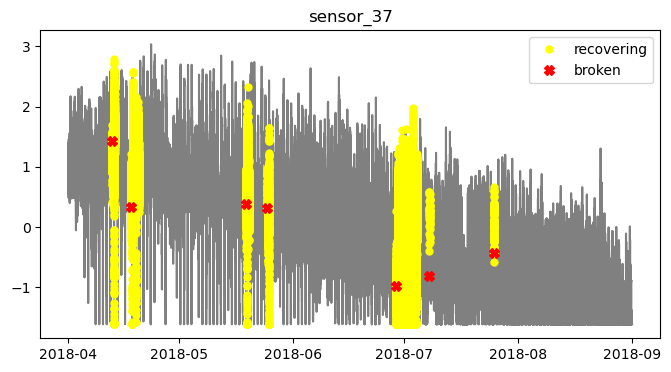

In [45]:
anomaly.plot_sensor(column='sensor_37')

The signal has high variance. This makes it harder to distinguish real anomalies from random fluctuations.

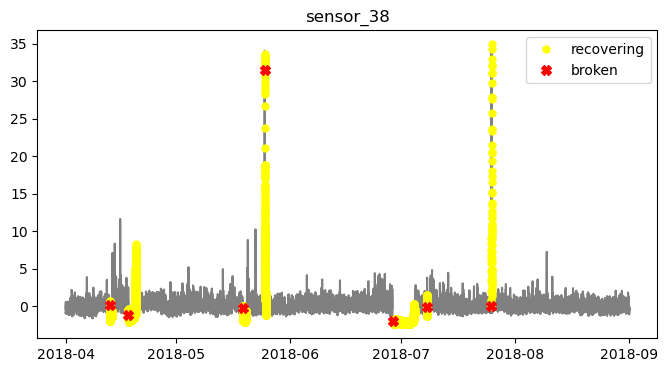

In [46]:
anomaly.plot_sensor(column='sensor_38')

The signal seems reliable

Based on our analysis, we decided to remove the following sensors to test whether their removal improves the efficiency and reliability of anomaly detection.

In [ ]:
sensors[13:38]

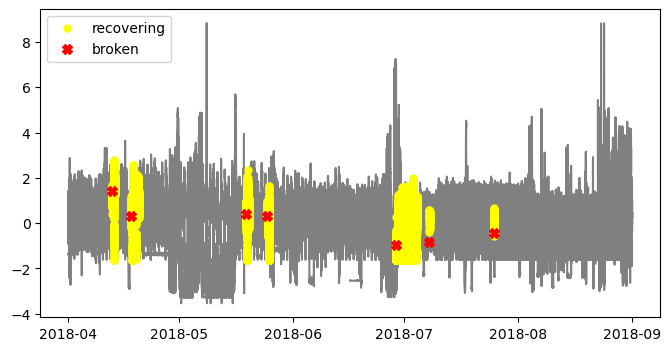

In [48]:
anomaly.plot_sensor(column=sensors[14:37])

The region around **'2018-05'** shows a **clear deviation** compared to the rest of the data, indicating a potential anomaly. However, the machine was reported to be **operating normally** when the sensors emitted these signals, suggesting that the detected deviation might be caused by **sensor noise or external factors** rather than an actual machine malfunction. We identified the following sensors as unreliable and conducted experiments by excluding them to assess their impact on overall performance.

## Anomaly Detection with clean Data

In [49]:
reduced_cols = sensors[:13]+sensors[37:]+['machine_status','timestamp']
reduced_df = df[reduced_cols]

In [50]:
anomaly_v2 = Anomaly(reduced_df)

/Users/eshita-pc/Documents/BFVM23DATASC6/Anomaly_detection/anamoly.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['timestamp'] = pd.to_datetime(df['timestamp'])


#### Isolation Forest

In [51]:
isolation_forest_preds_clean = anomaly_v2.anomaly_detection(isolation_forest)

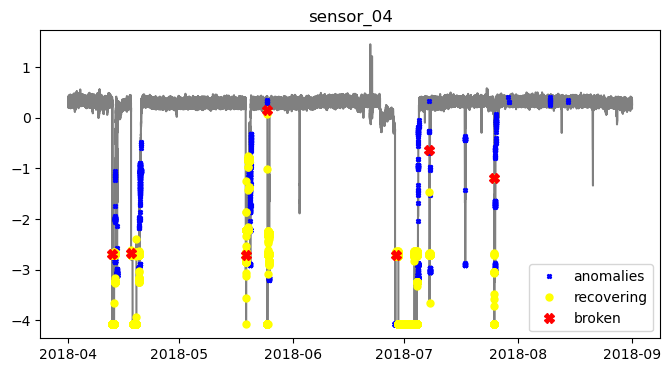

In [52]:
anomaly_v2.plot_sensor(column = 'sensor_04', preds=isolation_forest_preds_clean)

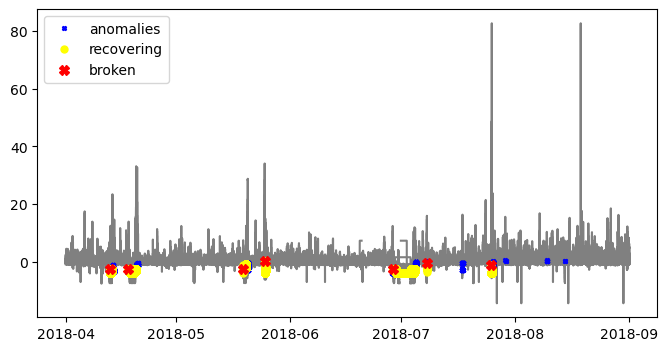

In [53]:
anomaly_v2.plot_sensor(preds=isolation_forest_preds_clean)

After removing the malicious sensors, we could see that isolation forest is detecting anomalies near the broken or recovering state instead of big chunk of normal cases. Especially in the all the sensors plots this shows more prominent. We can understand this improvement more clearly by comparing the AUC scores before and after data cleaning.

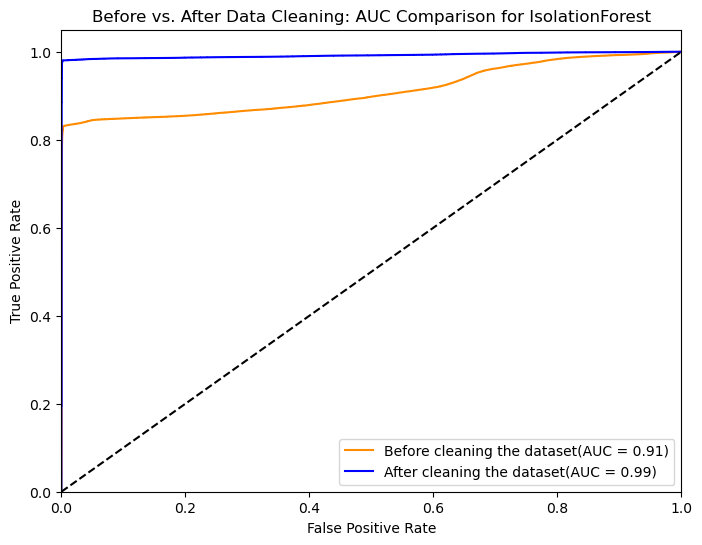

In [54]:
tpr_iso2, fpr_iso_2,auc_iso2 = anomaly_v2.return_tpr_fpr_auc(isolation_forest, anomaly_v2.X, anomaly_v2.return_target())
anomaly.before_after_auc_plot(model_name_iso,tpr_iso1, fpr_iso_1,auc_iso1, tpr_iso2, fpr_iso_2,auc_iso2)

After cleaning the dataset, `AUC` score is improved from .91 to .99. This suggest the model is identifying the anomalies more clearly.

              precision    recall  f1-score   support

     Anomaly       0.85      0.85      0.85     14484
      Normal       0.99      0.99      0.99    205836

    accuracy                           0.98    220320
   macro avg       0.92      0.92      0.92    220320
weighted avg       0.98      0.98      0.98    220320



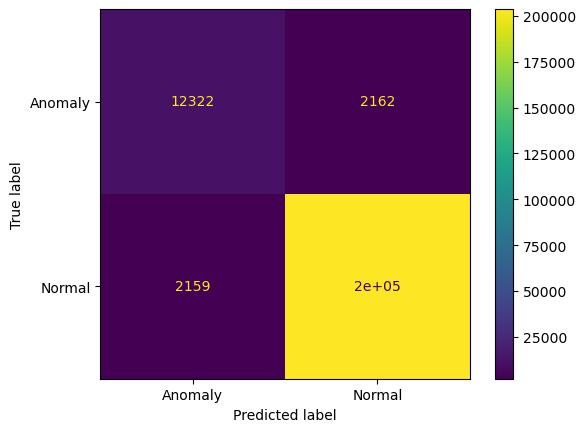

In [55]:
anomaly_v2.evaluation(isolation_forest_preds_clean)

The changes are very clear after removing unreliable sensors. Number of false positves reduced to 2162 from 8K. The f1 score for Anomaly is also improved from 0.42 to 0.81. 

#### SVM 

In [56]:
svm_one_class_preds_clean = anomaly_v2.anomaly_detection(svm_one_class)

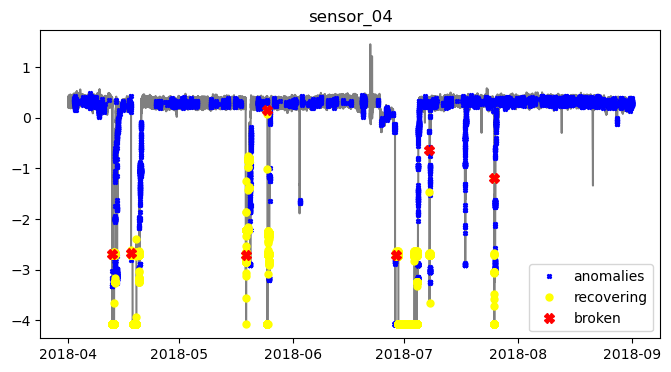

In [57]:
anomaly_v2.plot_sensor(column = 'sensor_04',preds=svm_one_class_preds_clean)

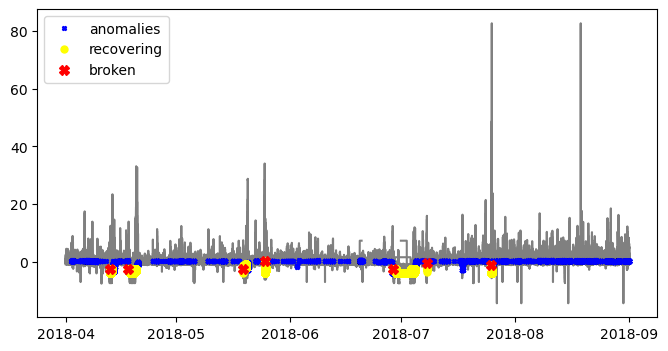

In [58]:
anomaly_v2.plot_sensor(preds=svm_one_class_preds_clean)

From individual sensor plot or all the sensor plot, we could see that `One Class Support Vector Machine` has identified lots of normal datapoints as anomalies. And it didn't improve after data cleaning. 

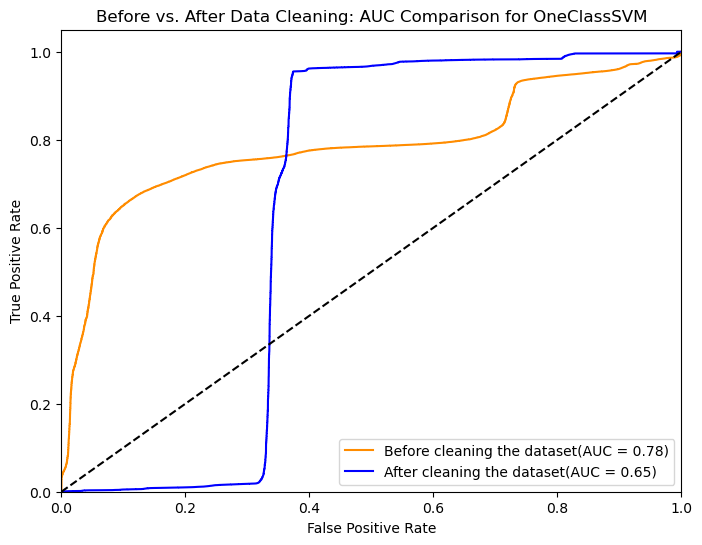

In [59]:
tpr_svm2, fpr_svm_2,auc_svm2 = anomaly.return_tpr_fpr_auc(svm_one_class, anomaly_v2.X, anomaly_v2.return_target())
anomaly.before_after_auc_plot(model_name_svm,tpr_svm1, fpr_svm_1,auc_svm1,tpr_svm2, fpr_svm_2,auc_svm2)

After cleaning (blue curve), the AUC drops to 0.65, suggesting that data cleaning may have removed useful signals for detecting anomalies. After cleaning (blue curve), the AUC drops to 0.65, suggesting that data cleaning may have removed useful signals for detecting anomalies.

              precision    recall  f1-score   support

     Anomaly       0.49      0.49      0.49     14484
      Normal       0.96      0.96      0.96    205836

    accuracy                           0.93    220320
   macro avg       0.73      0.73      0.73    220320
weighted avg       0.93      0.93      0.93    220320



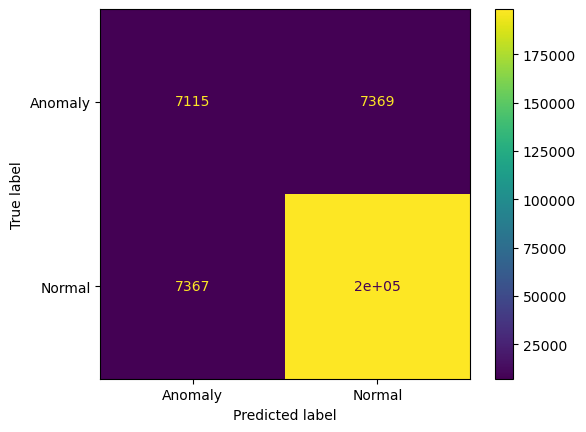

In [60]:
anomaly_v2.evaluation(svm_one_class_preds_clean)

The changes are not very promising after removing unreliable sensors. Number of false positves reduced to 7428 from 8K. The f1 score for Anomaly is also improved from 0.42 to 0.49.

### Local Outlier Factor

In [61]:
local_outliner_preds_clean = anomaly_v2.anomaly_detection(local_outliner, local_outlier=True)

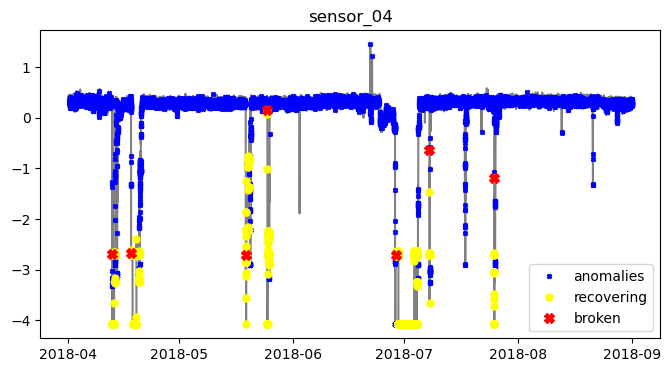

In [62]:
anomaly_v2.plot_sensor(column = 'sensor_04',preds=local_outliner_preds_clean)

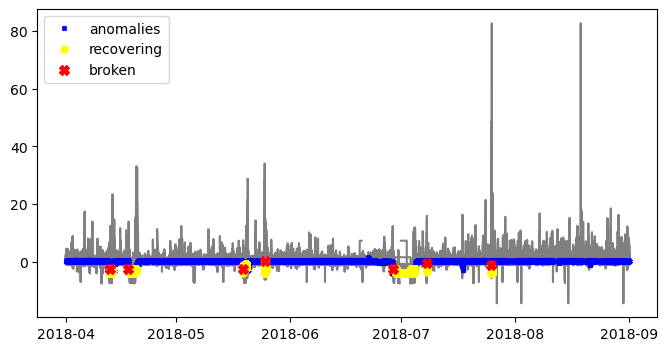

In [63]:
anomaly_v2.plot_sensor(preds=local_outliner_preds_clean)

It's very similar to what we observed before cleaning the data.Data cleaning did not help `LOF` on detecting anomalies.

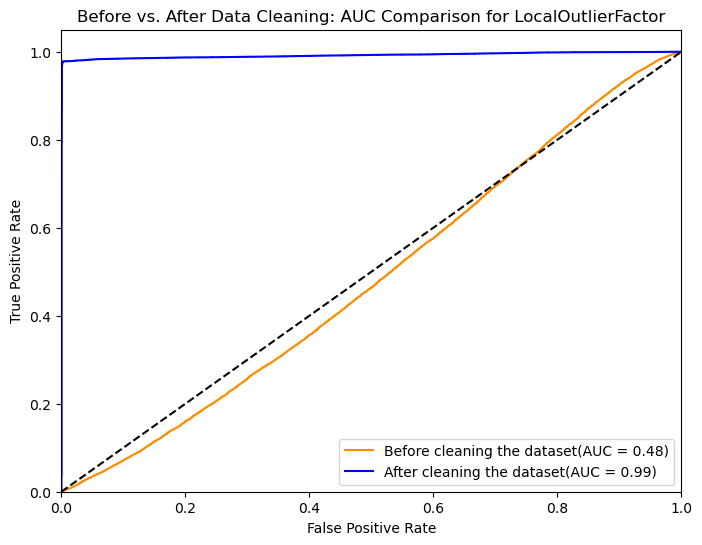

In [64]:
tpr_local2, fpr_local_2,auc_local2 = anomaly_v2.return_tpr_fpr_auc(isolation_forest, anomaly_v2.X, anomaly_v2.return_target())
anomaly.before_after_auc_plot(model_name_local,tpr_local1, fpr_local1,auc_local1, tpr_local2, fpr_local_2,auc_local2)

After cleaning, we see similar outcome from `Robust Covaraince` before cleaning the data. A high `AUC` score means the model performs well overall. However, the flat curve shows that it makes a lot of mistakes by labeling normal data as anomalies.

              precision    recall  f1-score   support

     Anomaly       0.19      0.19      0.19     14484
      Normal       0.94      0.94      0.94    205836

    accuracy                           0.89    220320
   macro avg       0.56      0.56      0.56    220320
weighted avg       0.89      0.89      0.89    220320



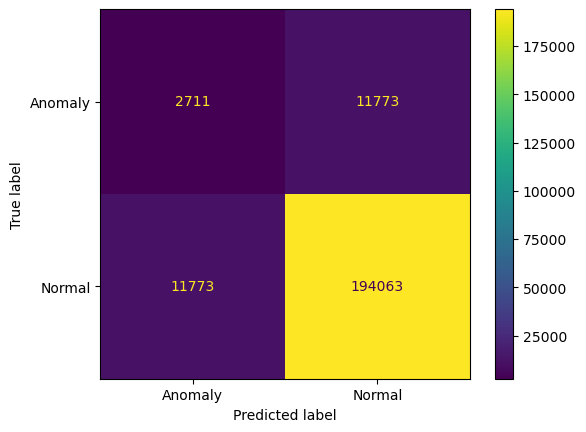

In [65]:
anomaly_v2.evaluation(local_outliner_preds_clean)

The changes are not very promising after removing unreliable sensors. Number of false positves reduced to 11479 from 12K. The f1 score for Anomaly is also improved from 0.16 to 0.19. 

### Robust covariance

In [66]:
robust_covariance_preds_clean = anomaly_v2.anomaly_detection(robust_covariance)

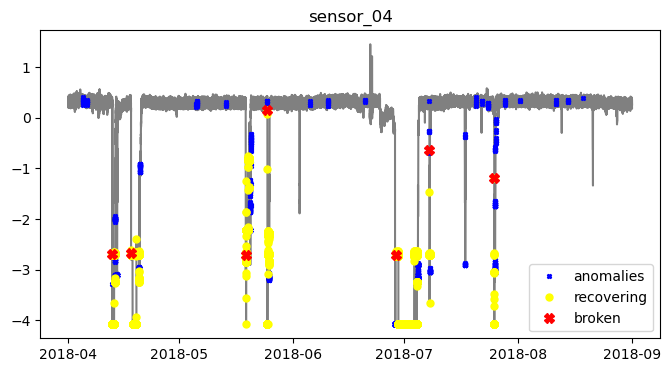

In [67]:
anomaly_v2.plot_sensor(column = 'sensor_04',preds=robust_covariance_preds_clean)

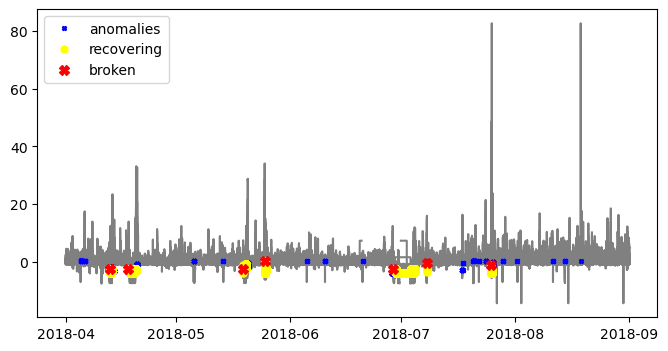

In [68]:
anomaly_v2.plot_sensor(preds=robust_covariance_preds_clean)

After cleaning the data, we can see noticeable improvements, with predictions aligning more closely with actual anomalies.

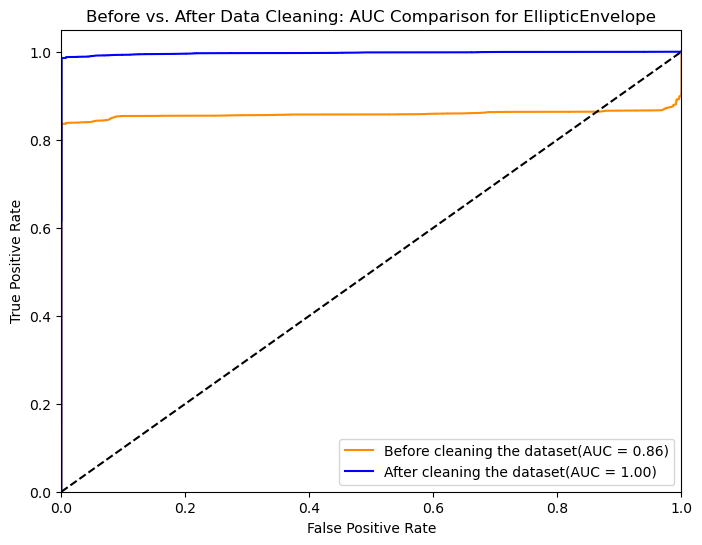

In [69]:
tpr_robust2, fpr_robust_2,auc_robust2 = anomaly_v2.return_tpr_fpr_auc(robust_covariance, anomaly_v2.X, anomaly_v2.return_target())
anomaly.before_after_auc_plot(model_name_robust,tpr_robust1, fpr_robust1,auc_robust1, tpr_robust2, fpr_robust_2,auc_robust2)

After cleaning the dataset, `AUC` score is improved from .86 to 1.0. This suggest the model is identifying the anomalies in a better way compared to what it was doing before.

              precision    recall  f1-score   support

     Anomaly       0.90      0.90      0.90     14484
      Normal       0.99      0.99      0.99    205836

    accuracy                           0.99    220320
   macro avg       0.95      0.95      0.95    220320
weighted avg       0.99      0.99      0.99    220320



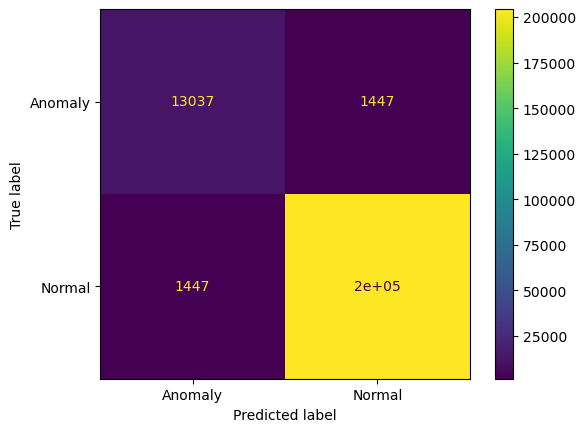

In [70]:
anomaly_v2.evaluation(robust_covariance_preds_clean)

The changes are very promising after removing unreliable sensors. Number of false positves reduced to 1432 from 14K. The f1 score for Anomaly is also improved from 0.00 to 0.90.

## Conclusion

After removing unreliable sensors from the dataset, we saw a big improvement in performance with Isolation Forest and Robust Covariance. Robust Covariance, in particular, improved significantly, with its F1 score jumping from 0.0 to 0.90. Meanwhile, SVM and LOF showed little change, suggesting they are very sensitive to the data and can detect anomalies even with small differences.  

Our findings support our hypothesis that Isolation Forest and Robust Covariance are effective at detecting pump failures from abnormal signals. Isolation Forest achieved an AUC of 0.99 and an F1 score of 0.85, while Robust Covariance had an AUC of 1.0 and an F1 score of 0.90. In contrast, SVM and LOF performed poorly, with high false positive rates and low AUC scores. Therefore, for this pump dataset, Isolation Forest and Robust Covariance are the most reliable methods.

**Reasons for Improvement (Isolation Forest):**
- **Reduced Noise:** Isolation Forest isolates anomalies based on feature distributions, and noisy features can lead to incorrect splits in the isolation trees. Removing unreliable sensors allows the model to focus on meaningful patterns, improving accuracy.
- **Stable Decision Boundaries:** The randomness in tree splits is affected by unreliable features. By removing these, the model creates more stable and consistent decision boundaries, improving performance.

**Reasons for Improvement (Robust Covariance):**
- **Better Covariance Estimation:** The algorithm calculates the covariance matrix of the data. Unreliable sensors introduce artificial correlations that disrupt this calculation. Removing them results in a more accurate covariance matrix and better anomaly detection.
- **Improved Mahalanobis Distance Calculation:** Robust Covariance uses Mahalanobis distance to measure how much a point deviates from the normal data distribution. If unreliable sensors distort the distribution, even normal points may appear as anomalies. Removing these sensors ensures a more reliable distance calculation.

**Why LOF did not improve:**
- LOF detects anomalies by comparing the density of a point to its neighbors. If a dataset has noise, LOF still focuses on local relationships rather than global patterns. Removing unreliable sensors does not necessarily change the local density structure, meaning LOF may still identify the same anomalies.
- LOF is highly sensitive to small changes in density, meaning even minor variations in feature values can significantly alter anomaly scores. Since unreliable sensors might have introduced some random fluctuations but not drastic density changes, removing them did not strongly affect the model’s decision-making.

**Why SVM did not improve:**
- Unlike Robust Covariance (which assumes a structured feature distribution), One-class-SVM focuses on maximizing the margin between normal data and anomalies. Unless unreliable sensors cause extreme distortions, removing them does not dramatically impact model performance.

## References
[1] Fawcett, T. (2006). An introduction to ROC analysis. Pattern Recognition Letters, 27(8), 861–874. doi:10.1016/j.patrec.2005.10.010

[2] Goldstein, M. (2015). Unsupervised anomaly detection benchmark [Data set]. doi:10.7910/DVN/OPQMVF

[3] Lungana-Niculescu, A. M., Colesa, A., & Oprisa, C. (2018, September). False positive mitigation in behavioral malware detection using deep learning. 2018 IEEE 14th International Conference on Intelligent Computer Communication and Processing (ICCP), 197–203. Presented at the 2018 IEEE 14th International Conference on Intelligent Computer Communication and Processing (ICCP), Cluj-Napoca. doi:10.1109/iccp.2018.8516611

[4]  López, D., Aguilera-Martos, I., García-Barzana, M., Herrera, F., García-Gil, D., & Luengo, J. (2023). Fusing anomaly detection with false positive mitigation methodology for predictive maintenance under multivariate time series. An International Journal on Information Fusion, 100(101957), 101957. doi:10.1016/j.inffus.2023.101957